## Clone and install custom gym

In [1]:
# Clone and install Sigurds version of the gym
!git clone -b master_student_branch https://github.com/sigurdhjerde/gym.git

%cd gym/
!git branch

!ls
!pip install -e .

Cloning into 'gym'...
remote: Enumerating objects: 10116, done.
remote: Total 10116 (delta 0), reused 0 (delta 0), pack-reused 10116
Receiving objects: 100% (10116/10116), 5.17 MiB | 22.74 MiB/s, done.
Resolving deltas: 100% (6899/6899), done.
/content/gym
* master_student_branch
bin		     LICENSE.md		   scripts		  tox.ini
CODE_OF_CONDUCT.rst  Makefile		   setup.py		  unittest.cfg
docs		     README.rst		   test.dockerfile.14.04  vendor
examples	     requirements_dev.txt  test.dockerfile.16.04
gym		     requirements.txt	   test.dockerfile.18.04
Obtaining file:///content/gym
ERROR: stable-baselines 2.2.1 has requirement gym[atari,classic_control]>=0.10.9, but you'll have gym 0.10.8 which is incompatible.
  Found existing installation: gym 0.15.4
    Uninstalling gym-0.15.4:
      Successfully uninstalled gym-0.15.4
  Running setup.py develop for gym


## Import modules

In [0]:
import random
from collections import deque

import gym
import numpy as np

from gym.envs.diabetes.meal_generator.meal_generator import meal_generator

import torch as th
import torch.nn as nn
import torch.optim as optim

from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# **Replay buffer class**

In [0]:
class ReplayBuffer(object):
  def __init__(self, capacity):
    self.buffer = deque(maxlen = capacity)

  def push(self, state, action, reward, next_state, done):
    state      = np.expand_dims(state, 0)
    next_state = np.expand_dims(next_state, 0)

    self.buffer.append((state, action, reward, next_state, done))
  
  def sample(self, batch_size):
    state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
    return np.concatenate(state), action, reward, np.concatenate(next_state), done
  
  def __len__(self):
    return len(self.buffer)

## Initiate environment

In [4]:
env_id = 'HovorkaCambridge-v0'
db = gym.make(env_id)

/content/gym/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


## Hyperparameters

In [0]:
N_states = db.observation_space.shape[0]
N_actions = db.action_space.n

learning_rate = 1e-3
buffer_size = int(1e5)
batch_size = 128
gamma = 0.99
max_steps = int(1e5)

eps_init  = 1.0
eps_end   = 0.01
eps_decay = 2e4

eps_by_step = lambda t: eps_end + (eps_init - eps_end) * np.exp(-1.*t / eps_decay)

# **Double Deep Q Network**

In [0]:
class DDQN(nn.Module):
  def __init__(self, N_states, N_actions):
    super(DDQN, self).__init__()

    self.layers = nn.Sequential(
        nn.Linear(N_states, 64),
        nn.ReLU(),
        nn.Linear(64, 64),
        nn.ReLU(),
        nn.Linear(64, 64),
        nn.ReLU(),
        nn.Linear(64, 64),
        nn.ReLU(),
        nn.Linear(64, N_actions)
    )
  
  def forward(self, x):
    return self.layers(x)
  
  def choose_action(self, state, epsilon):
    if random.random() > epsilon:
      state  = th.FloatTensor(state).unsqueeze(0)
      q      = self.forward(state)
      action = np.argmax(q.detach().numpy())
    else:
      action = random.randrange(N_actions)
    return action 

## Initiate model, optimizer, loss function and replay buffer

In [0]:
model_local   = DDQN(N_states, N_actions)
model_target  = DDQN(N_states, N_actions)
optimizer     = optim.Adam(model_local.parameters(), lr=learning_rate)
loss          = nn.MSELoss()
replay_buffer = ReplayBuffer(buffer_size) 

## Target network update

In [0]:
def update_target(model_local, model_target):
  model_target.load_state_dict(model_local.state_dict())

In [0]:
update_target(model_local, model_target)

# **Learn function**

In [0]:
def learn(batch_size):
  state, action, reward, next_state, done = replay_buffer.sample(batch_size)

  state      = th.FloatTensor(np.float32(state))
  action     = th.LongTensor(action)
  reward     = th.FloatTensor(reward)
  next_state = th.FloatTensor(np.float32(next_state))
  done       = th.FloatTensor(done)

  q_values_current = model_local(state)
  q_values_next    = model_local(next_state)
  next_q_states    = model_target(next_state)

  Q      = q_values_current.gather(1, action.unsqueeze(1)).squeeze(1)
  Q_next = next_q_states.gather(1, th.max(q_values_next, 1)[1].unsqueeze(1)).squeeze(1)
  Q_expected = reward + gamma * Q_next * (1 - done)

  loss_train = loss(Q, Q_expected.data)

  optimizer.zero_grad()
  loss_train.backward()
  optimizer.step()

  return loss_train

# **Train model**

In [11]:
loss_list      = []
reward_list    = []
epsiode_reward = 0
episode_count  = 0

meals, meal_indicator = meal_generator()
db.env.meals          = meals
db.env.meal_indicator = meal_indicator

db.env.reset_basal_manually = db.env.init_basal_optimal
state = db.reset()

for t in range(1, max_steps + 1):
  epsilon = eps_by_step(t)

  action = model_local.choose_action(state, epsilon)
  next_state, reward, done, _ = db.step(action)

  replay_buffer.push(state, action, reward, next_state, done)
  
  state = next_state
  epsiode_reward += reward

  if done:
    meals, meal_indicator = meal_generator()
    db.env.meals          = meals
    db.env.meal_indicator = meal_indicator

    db.env.reset_basal_manually = db.env.init_basal_optimal
    state = db.reset()

    reward_list.append(epsiode_reward)
    epsiode_reward = 0
    episode_count += 1

    if episode_count % 100 == 0:
      print("Episode: {}".format(episode_count))
      print("Time step: {}".format(t))
      print("Mean 100 episode reward: {}".format(np.mean(reward_list[-100:])))
      print("Epsilon: {}".format(epsilon))

  
  if replay_buffer.__len__() > batch_size:
    loss_train = learn(batch_size)
    loss_list.append(loss_train.item())
  
  if t % 100 == 0:
    update_target(model_local, model_target)

Episode: 100
Time step: 7200
Mean 100 episode reward: 34.35512970078179
Epsilon: 0.7006995628103208
Episode: 200
Time step: 14400
Mean 100 episode reward: 41.633829388106044
Epsilon: 0.491884733400372
Episode: 300
Time step: 21600
Mean 100 episode reward: 43.86793643541571
Epsilon: 0.34619957038848975
Episode: 400
Time step: 28756
Mean 100 episode reward: 41.863570584656564
Epsilon: 0.2450750778017266
Episode: 500
Time step: 35956
Mean 100 episode reward: 44.36741066642002
Epsilon: 0.1740063166315704
Episode: 600
Time step: 43156
Mean 100 episode reward: 43.01053880808918
Epsilon: 0.12442332443995628
Episode: 700
Time step: 50356
Mean 100 episode reward: 44.80355604192191
Epsilon: 0.08983044461210232
Episode: 800
Time step: 57556
Mean 100 episode reward: 43.956868862698435
Epsilon: 0.06569581130558848
Episode: 900
Time step: 64756
Mean 100 episode reward: 45.60465237418719
Epsilon: 0.048857649009228364
Episode: 1000
Time step: 71956
Mean 100 episode reward: 45.69792005341874
Epsilon: 0

# Test episode

In [0]:
def test_episode(model):
  done = False
  meals, meal_indicator = meal_generator()
  db.env.meals          = meals
  db.env.meal_indicator = meal_indicator

  db.env.reset_basal_manually = db.env.init_basal_optimal
  state = db.reset()
  action_list = []

  while not done:
    action = model.choose_action(state, 0)
    state, reward, done, _ = db.step(action)

    action_list.append(action)
  
  bg_hist = db.env.bg_history

  plt.figure()
  plt.plot(bg_hist)
  plt.title('Test episode')
  plt.xlabel('Time')
  plt.ylabel('Blood glucose')
  plt.axhline(y=70, c='red', ls='--', alpha=0.9)
  plt.axhline(y=180, c='red', ls='--', alpha=0.9)
  plt.show()

  plt.figure()
  plt.plot(action_list)
  plt.title('Actions taken over time')
  plt.xlabel('Time')
  plt.ylabel('Actions')
  plt.show()

  TAR = sum(bg_hist > 180)/len(bg_hist) * 100
  TBR = sum(bg_hist < 70)/len(bg_hist) * 100
  TIR = 100 - (TAR + TBR)
      
  print("TIR: {}%".format(round(TIR, 2)))
  print("TAR: {}%".format(round(TAR, 2)))
  print("TBR: {}%".format(round(TBR, 2)))

  return bg_hist, np.array(action_list)

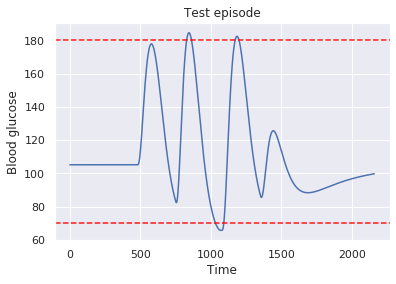

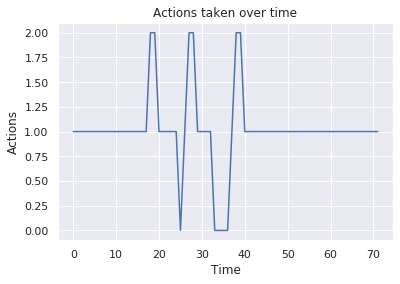

TIR: 94.4%
TAR: 2.87%
TBR: 2.73%


In [21]:
bg_hist_test, action_list_test = test_episode(model_local)

# Learning curve plot

In [0]:
def learning_curve(rewards):
  y = rewards
  w = np.ones(50)

  y_w = 2*y[0] - np.flip(y[0:50], 0)
  y_w = np.concatenate([y_w, np.asarray(y[:])])
  y_w = np.concatenate([y_w, 2*y[-1] - np.flip(y[-1-50:-1], 0)])

  y_smooth = np.convolve(y_w, w/sum(w))

  idx = int(np.floor(1.5*50))
  reward_smooth = y_smooth[idx:-1-idx-2]

  plt.figure()
  plt.plot(y)
  plt.plot(reward_smooth)
  plt.title("Learning curve")
  plt.xlabel("Episodes")
  plt.ylabel("Returns")
  plt.legend(["Learning curve", "Learning curve smoothed"], loc='best')

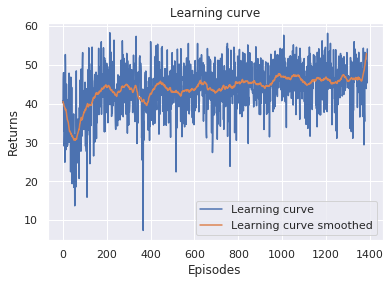

In [24]:
learning_curve(reward_list)

# Mean blood glucose history plot

In [0]:
def mean_bg_history(model):
  bg_list = []

  for i in range(100):
    done = False
    meals, meal_indicator = meal_generator()
    db.env.meals = meals
    db.env.meal_indicator = meal_indicator
            
    db.env.reset_basal_manually = db.env.init_basal_optimal
    state = db.reset()

    while not done:
      action = model.choose_action(state, 0)
      state, reward, done, _ = db.step(action)
    
    bg_list.append(db.env.bg_history)

  mean_bg_min = np.mean(bg_list, 0)
  std_bg_min  = np.std(bg_list, 0)
  mean_bg_epi = np.mean(bg_list, 1)
  std_bg_epi  = np.std(bg_list, 1)

  low_bound = mean_bg_min - std_bg_min
  high_bound = mean_bg_min + std_bg_min

  bg_low  = 70
  bg_high = 180

  TBR = sum(mean_bg_min < bg_low)/len(mean_bg_min) * 100
  TAR = sum(mean_bg_min > bg_high)/len(mean_bg_min) * 100
  TIR = 100 - (TBR + TAR)

  plt.figure()
  plt.plot(mean_bg_min)
  plt.fill_between(np.linspace(0, 2160, 2160), low_bound, high_bound,
                   alpha=0.3, edgecolor='#1B2ACC', facecolor='#089FFF')
  plt.title('Mean blood glucose per minute')
  plt.xlabel('Time steps')
  plt.ylabel('Blood glucose')
  plt.axhline(y = bg_low, c='red', ls='--', alpha=0.9)
  plt.axhline(y = bg_high, c='red', ls='--', alpha=0.9)
  plt.show()

  print("TBR: {}%".format(round(TBR, 2)))
  print("TAR: {}%".format(round(TAR, 2)))
  print("TIR: {}%".format(round(TIR, 2)))

  return mean_bg_min, low_bound, high_bound, mean_bg_epi, std_bg_epi

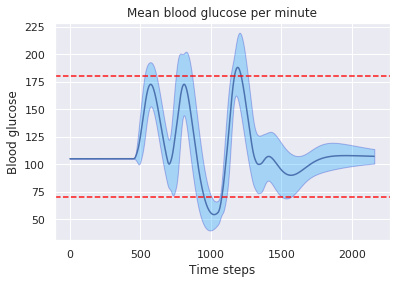

TBR: 5.74%
TAR: 2.27%
TIR: 91.99%


In [35]:
mean_bg_min, low_bound, high_bound, mean_bg_epi, std_bg_epi = mean_bg_history(model_local)

In [28]:
(mean_bg_epi.mean(), std_bg_epi.mean())

(111.67243321169549, 33.30968005657368)

# Time-in-range estimate

In [0]:
def time_in_range(model):
  bg_low  = 70
  bg_high = 180

  TBR_list = []
  TAR_list = []
  TIR_list = []

  for i in range(14):
    done = False
    meals, meal_indicator = meal_generator()
    db.env.meals          = meals
    db.env.meal_indicator = meal_indicator

    db.env.reset_basal_manually = db.env.init_basal_optimal
    state = db.reset()

    while not done:
      action = model.choose_action(state, 0)
      state, reward, done, _ = db.step(action)
    
    bg_hist = db.env.bg_history

    TBR = sum(bg_hist < bg_low)/len(bg_hist) * 100
    TAR = sum(bg_hist > bg_high)/len(bg_hist) * 100
    TIR = 100 - (TBR + TAR)

    TBR_list.append(TBR)
    TAR_list.append(TAR)
    TIR_list.append(TIR)

  print("Mean TIR: {}%".format(round(np.mean(TIR_list), 2)))
  print("Mean TAR: {}%".format(round(np.mean(TAR_list), 2)))
  print("Mean TBR: {}%".format(round(np.mean(TBR_list), 2)))

In [45]:
time_in_range(model_local)  

Mean TIR: 88.44%
Mean TAR: 4.35%
Mean TBR: 7.22%


# Skip meals

In [0]:
def mean_bg_history_meal_skip(model):
  # Test meals with a set seed
  todays_seed = 100
  n_test_scenarios = 100

  bg_list = []
  actions_epi = []
  action_list = []

  for k in range(n_test_scenarios):
    m = meal_generator(seed=todays_seed + k)
    db.env.meals = m[0]

    # With some probability skip a bolus at random
    if np.random.rand() < .1:
      m[1][np.random.choice(np.squeeze(np.nonzero(m[1])))] = 0
  
    db.env.meal_indicator = m[1]

    db.env.reset_basal_manually = db.env.init_basal_optimal
    state = db.reset()
    for i in range(72):
      action = model.choose_action(state, 0)
      state, reward, done, _ = db.step(action)

      actions_epi.append(action)
    
    for i in range(len(actions_epi)):
      if actions_epi[i] == 1:
        actions_epi[i] = 6.43
      elif actions_epi[i] == 2:
        actions_epi[i] = 3*6.43
  
    bg_list.append(db.env.bg_history)
    action_list.append(actions_epi)

  mean_bg_min = np.mean(bg_list, 0)
  std_bg_min  = np.std(bg_list, 0)
  mean_bg_epi = np.mean(bg_list, 1)
  std_bg_epi  = np.std(bg_list, 1)

  low_bound = mean_bg_min - std_bg_min
  high_bound = mean_bg_min + std_bg_min

  bg_low  = 70
  bg_high = 180

  TBR = sum(mean_bg_min < bg_low)/len(mean_bg_min) * 100
  TAR = sum(mean_bg_min > bg_high)/len(mean_bg_min) * 100
  TIR = 100 - (TBR + TAR)

  plt.figure()
  plt.plot(mean_bg_min)
  plt.fill_between(np.linspace(0, 2160, 2160), low_bound, high_bound,
                   alpha=0.3, edgecolor='#1B2ACC', facecolor='#089FFF')
  plt.title('Mean blood glucose per minute')
  plt.xlabel('Time steps')
  plt.ylabel('Blood glucose')
  plt.axhline(y = bg_low, c='red', ls='--', alpha=0.9)
  plt.axhline(y = bg_high, c='red', ls='--', alpha=0.9)
  plt.show()

  print("TBR: {}%".format(round(TBR, 2)))
  print("TAR: {}%".format(round(TAR, 2)))
  print("TIR: {}%".format(round(TIR, 2)))

  mean_action_epi = np.mean(action_list, 1)
  std_action_epi = np.std(action_list, 1)

  return mean_bg_min, low_bound, high_bound, mean_bg_epi, std_bg_epi, mean_action_epi, std_action_epi

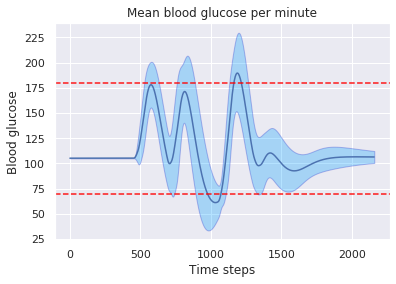

TBR: 4.4%
TAR: 2.45%
TIR: 93.15%


In [58]:
mean_bg_min_ms, low_bound_ms, high_bound_ms, mean_bg_epi_ms, std_bg_epi_ms, mean_action_epi_ms, std_action_epi_ms = mean_bg_history_meal_skip(model_local)

In [48]:
np.mean(mean_bg_epi_ms), np.mean(std_bg_epi_ms)

(113.32949293537176, 35.58639918956082)

In [49]:
np.mean(mean_action_epi_ms), np.mean(std_action_epi_ms)

(7.04710138888889, 4.724265492674585)

# **Save data**

In [0]:
import csv

#Save test episode with actions
# np.savetxt("bg_hist_test.csv", bg_hist_test, delimiter=",")
# np.savetxt("actions_test.csv", action_list_test, delimiter=",")

# Save all rewards
# np.savetxt("ddqn_rewards.csv", reward_list, delimiter=",")

# Save mean BG per minute and boundaries
# np.savetxt("mean_bg_min.csv", mean_bg_min, delimiter=",")
# np.savetxt("low_bound.csv", low_bound, delimiter=",")
# np.savetxt("high_bound.csv", high_bound, delimiter=",")

# Save mean BG per minute and boundaries when doing meal skips
np.savetxt("mean_bg_min_ms.csv", mean_bg_min_ms, delimiter=",")
np.savetxt("low_bound_ms.csv", low_bound_ms, delimiter=",")
np.savetxt("high_bound_ms.csv", high_bound_ms, delimiter=",")